<a href="https://colab.research.google.com/github/Alecia113/NLP-Ex/blob/main/E9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise




## E1. Explain the difference between coreference and anaphora with the example. (Your answer will not be marked if you do not add the example)

 用**例子**解释**核心推理**和**拟人**之间的**区别**。如果你不添加例子，你的答案将不会被评分
 coreference ————anaphora

Your answer: coreference： 代指； Hospital ……it ； anaphora：重复， Hospital…… hospital……

## E2. Try Bi-LSTM with CRF!

Now we will apply the Bi-LSTM CRF model we just learned to CoNLL 2003 NER dataset using the pretrained glove embeddings. Please go through and complete the [Function for accuracy] section. 
现在我们将把刚刚学到的Bi-LSTM CRF模型应用于CoNLL 2003 NER数据集，使用预训练的手套嵌入。请浏览并完成[准确性的功能]部分。

### Download Dataset

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate
drive = None
def authenticate():
    global drive
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

#Download files
def downloadFiles(fileIds):
    authenticate()
    for fileId in fileIds:    
        downloaded = drive.CreateFile({"id": fileId[1]})
        downloaded.GetContentFile(fileId[0])

In [2]:
#Download file if not existing
try:
  _ = open("train.txt", "r")
except:
  downloadFiles([["train.txt", "1UmNHdUZxjfcuIzCcAKuBvfBXdSWFv47i"]])

try:
  _ = open("validation.txt", "r")
except:
  downloadFiles([["validation.txt", "11bZIh5V9m2nZJ5s5xQ_gxHEHkAEhV8eQ"]])

try:
  _ = open("test.txt", "r")
except:
  downloadFiles([["test.txt", "1V-LQuJWT62aCytYuhZuaxvICsqiF1rdK"]])

In [3]:
def read_data(file_name, n_sample):
    f = open(file_name)
    documents = f.readlines()

    input_data = []
    target_data = []

    temp1 = []
    temp2 = []
    for i in documents:
        if i == '\n':
            input_data.append(temp1)
            target_data.append(temp2)
            temp1 = []
            temp2 = []
        else:
            temp1.append(i.replace('\n','').split(' ')[0].lower())
            temp2.append(i.replace('\n','').split(' ')[3])
    return input_data[:n_sample], target_data[:n_sample]

train_data, target_y_train = read_data("train.txt",400)   # ['york', ',', 'england', '1996-08-22']]一维一句话，二维一个token 
# ['I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],400 ,['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']一句话的标签；看起来像IO没看到B
validation_data, target_y_validation = read_data("validation.txt",50) #验证['london', '1996-08-30'],['I-LOC', 'O']
test_data, target_y_test = read_data("test.txt",50) #['nadim', 'ladki']['I-PER', 'I-PER']

In [4]:
#给的例子
print(len(train_data))
print(train_data[1])
print(target_y_train[1])

400
['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']


### Preprocess

#### Generate word_to_ix and tag_to_ix

In [5]:
word_to_ix = {}     #进行了一波预处理
for sentence in train_data+validation_data+test_data:
    for word in sentence:
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())   #2351 token对应inde; index .keys 把关键的元素取出来。就是不要index;按顺序取的感觉

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {START_TAG:0, STOP_TAG:1}     #如下 ；还是BIO
for tags in target_y_train+target_y_validation:     #['O', 'O', 'O', 'I-ORG']
    for tag in tags:      #每一个的词的tag
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix) #就是又匹配上重新复制了。

'''
{'<START>': 0,
 '<STOP>': 1,
 'B-LOC': 7,
 'B-MISC': 8,
 'I-LOC': 6,
 'I-MISC': 4,
 'I-ORG': 3,
 'I-PER': 5,
 'O': 2}
 '''

"\n{'<START>': 0,\n '<STOP>': 1,\n 'B-LOC': 7,\n 'B-MISC': 8,\n 'I-LOC': 6,\n 'I-MISC': 4,\n 'I-ORG': 3,\n 'I-PER': 5,\n 'O': 2}\n "

#### Generate Embedding Matrix 把word变成word-embedding

In [6]:
import gensim.downloader as api
import numpy as np   #要加的
word_emb_model = api.load("glove-twitter-25") 

EMBEDDING_DIM = 25      #补充到25了

embedding_matrix = []
for word in word_list:
    try:
        embedding_matrix.append(word_emb_model.wv[word])
    except:
        embedding_matrix.append([0]*EMBEDDING_DIM)
embedding_matrix = np.array(embedding_matrix) #熟悉的节奏lookup tablel; 2维度
embedding_matrix.shape            #(2351, 25)

[==================================================] 100.0% 104.8/104.8MB downloaded


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


(2351, 25)

#### convert dataset into idxs   将数据集转换为idxs

In [7]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:         #sent 每句话
        input_index_list.append([to_ix[w] for w in sent])       #w是每个词    查询：【】词加'' word_to_ix['near'] 返回的是每个词的ind
    return input_index_list         # 把每个词的inde，又丢进list，一句话都是由inde组成，把这个数据集全都改成了index的模式

train_input_index =  to_index(train_data,word_to_ix)    # 句子toke，词字典['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']]-词典
train_output_index = to_index(target_y_train,tag_to_ix)   #每句没词类别，BIO类别典 ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']]-标签【真是】-表典
val_input_index = to_index(validation_data,word_to_ix)    # 句子toke，词字典
val_output_index = to_index(target_y_validation,tag_to_ix)    #每句没词类别，BIO类别典
test_input_index = to_index(test_data,word_to_ix)   # 句子toke，词字典
test_output_index = to_index(target_y_test,tag_to_ix)   #每句没词类别，BIO类别典

In [45]:
train_data[:2]


[['-docstart-'],
 ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']]

### Model

In [8]:
'''
随机数据

为CPU中设置种子，生成随机数
torch.manual_seed(number)   用的这
为特定GPU设置种子，生成随机数
torch.cuda.manual_seed(number)
为所有GPU设置种子，生成随机数
torch.cuda.manual_seed_all()

在需要生成随机数据的实验中，每次实验都需要生成数据。设置随机种子是为了确保每次生成固定的随机数，这就使得每次实验结果显示一致了，有利于实验的比较和改进。
'''
'''tag_to_ix
{'<START>': 0,
 '<STOP>': 1,
 'B-LOC': 7,
 'B-MISC': 8,
 'I-LOC': 6,
 'I-MISC': 4,
 'I-ORG': 3,
 'I-PER': 5,
 'O': 2}
 '''

"tag_to_ix\n{'<START>': 0,\n '<STOP>': 1,\n 'B-LOC': 7,\n 'B-MISC': 8,\n 'I-LOC': 6,\n 'I-MISC': 4,\n 'I-ORG': 3,\n 'I-PER': 5,\n 'O': 2}\n "

In [9]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)      #手册

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)    #2351, 类别的词典， 50 隐藏原。
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [12]:
torch.randn(9,9)

tensor([[ 1.1899,  0.8165, -0.9135,  1.3851, -0.8138, -0.9276,  1.1120,  0.6155,
          0.6043],
        [-0.1034, -0.1512, -2.1021, -0.6200, -1.4782, -1.1334, -0.1010, -0.5603,
          1.2858],
        [ 0.8168,  0.2053,  0.3051,  0.5357, -0.4312,  0.1573, -0.2334, -0.0135,
          1.8606],
        [-1.9804,  1.7986,  0.1018,  0.3400, -0.6447, -1.7765,  0.3539,  1.1996,
         -0.3030],
        [-1.7618,  0.6348, -0.8044, -1.0371, -1.8716,  0.5431,  0.6607,  2.2952,
          0.6749],
        [ 1.7133, -1.7943, -1.5208, -0.9832,  1.5113,  0.6419,  0.4730, -0.4286,
          0.5514],
        [-1.5474,  0.7575,  0.1065,  0.2692,  1.3248,  1.7460,  1.8550, -0.7064,
          2.5571],
        [ 0.7705, -0.2127,  0.5269,  1.6193, -0.9640,  0.1415, -0.1637, -0.3582,
         -0.0594],
        [-2.4919,  0.2389,  1.3440,  0.1032,  1.1004, -0.3417,  0.9473,  0.6223,
         -0.4481]])

In [13]:
A = torch.randn(2, 1, 50 // 2).to(device) # （2，1，25）  #init_hidden
A #torch.Size([2, 1, 25])   一维：第一个25 二维25 三维词  一组词又丢进一个list ；
B = torch.randn(2, 50 // 2).to(device)   #为什么要用1？，中间再嵌套进一个list
B
C = torch.randn(2, 1, 50 // 2).to(device),torch.randn(2, 1, 50 // 2).to(device) #hidden = 随机返回两个【2，1，25】
C

(tensor([[[-0.7030, -0.8268,  0.1012,  0.1952, -1.1796, -1.4423,  0.0748,
            0.3531, -0.0192,  1.1033,  0.5368,  0.9805, -1.1940, -0.4919,
            2.2788,  0.4707,  0.1450, -2.3442, -0.4619, -0.3686,  0.3682,
            0.4850,  0.2936, -0.4139, -0.3978]],
 
         [[-1.9291,  0.9264,  0.9134, -0.7902, -0.5831, -0.0339, -0.5396,
            1.6091, -0.0328,  0.3861,  1.0473, -0.7327, -0.9168, -0.8262,
           -0.2221, -1.7949,  0.7299,  0.7806, -2.2049, -1.4975, -0.9023,
            0.5935,  0.3314, -1.0592, -0.6280]]]),
 tensor([[[ 0.0402,  0.4647, -3.3793,  0.9732, -1.6804,  1.3299,  0.1383,
            1.0735,  1.3015, -0.6293, -0.0683,  0.6945,  1.2996,  0.4201,
            2.4291,  1.3981,  1.5365,  0.9193,  0.3453, -0.5506,  1.3261,
            0.5883, -1.2548,  1.3883,  1.1528]],
 
         [[-0.3997,  0.9738,  1.5453,  0.8202, -0.1630, -0.8551, -0.7517,
           -1.2308, -1.0655, -0.0639,  0.2609,  1.2374, -1.5462,  0.7172,
            0.7770, -0.0097,  0.2

In [14]:
D = torch.full((1, len(tag_to_ix)), -10000.).to(device)#tensor([[-10000., -10000., -10000., -10000., -10000., -10000., -10000., -10000., -10000.]])
D.shape #torch.Size([1, 9]) torch.full创建全相同的张量

torch.Size([1, 9])

In [15]:
tag_to_ix

{'<START>': 0,
 '<STOP>': 1,
 'B-LOC': 7,
 'B-MISC': 8,
 'I-LOC': 6,
 'I-MISC': 4,
 'I-ORG': 3,
 'I-PER': 5,
 'O': 2}

In [16]:
[tag_to_ix[START_TAG]]

[0]

In [17]:
D[0][[tag_to_ix[START_TAG]]] = 0 # 【取出来】【tensor([-10000.])取出第几个词】
D#tensor([[     0., -10000., -10000., -10000., -10000., -10000., -10000., -10000., -10000.]])
#forward_var = init_alphas = D

tensor([[     0., -10000., -10000., -10000., -10000., -10000., -10000., -10000.,
         -10000.]])

In [ ]:
for sentence in train_data+validation_data+test_data:
  print(sentence)#所有data的sentence
#sentence就是sentence

In [19]:
vocab_size = len(word_to_ix)
vocab_size

2351

In [20]:
embedding_dim = EMBEDDING_DIM = 25  
embedding_dim

25

In [21]:
word_embeds = nn.Embedding(vocab_size, embedding_dim) # 2351，25
word_embeds

Embedding(2351, 25)

In [22]:
len(sentence) #71句

71

In [23]:
#word_embeds(sentence).view(len(sentence),1,-1) #TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not list

In [24]:
word_embeds

Embedding(2351, 25)

In [25]:
 feats = self._get_lstm_features(sentence)

NameError: ignored

In [ ]:
# word_embeds = nn.Embedding(vocab_size, embedding_dim) # 2351，25
# #word_embeds = word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
# embeds = word_embeds(sentence).view(len(sentence), 1, -1) #71


In [33]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)      #手册
#最大值，最大分数
def argmax(vec):      
    # return the argmax as a python int# 将argmax作为一个Python int返回
    _, idx = torch.max(vec, 1)
    return idx.item()     #item() 方法是用来将只有一个元素的numpy数组或tensor张量转化为标量的方法
                          #Python 字典 items() 函数以列表返回可遍历的(键, 值) 元组数组。


# Compute log sum exp in a numerically stable way for the forward algorithm 以数字上稳定的方式计算正向算法的对数和exp 
#log_sum_exp(next_tag_var).view(1))
def log_sum_exp(vec):     #vec 可能= forward_var + trans_score + emit_score
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):    #vocab_size = 2351；字典里有多少词。类别词典 25最长embedding-长度（每个词）；hidden隐藏元50
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)     #传参了一波 9

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)    #2351，25

        """Here we use the embedding matrix as the initial weights of nn.Embedding"""""#这里我们使用嵌入矩阵作为nn.Embedding的初始权重""
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)#" // " 表示整数除法  25;50//2 ==25

        # Maps the output of the LSTM into tag space. 将LSTM的输出映射到标签空间。
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)   # 50,9

        # Matrix of transition parameters.  Entry i,j is the score of  过渡参数的矩阵。 第i,j项是
        # transitioning *to* i *from* j. 从*J过渡到*I。
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size)) #参数 （9，9）随机个9句9词；转化; 参数层

        # These two statements enforce the constraint that we never transfer # 这两个声明执行了一个约束条件，即我们永远不会转移
        # to the start tag and we never transfer from the stop tag  到开始标签，而我们从来没有从停止标签转移过
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()
#【3】
    def init_hidden(self):  ##hidden = 随机返回两个【2，1，25】 A   你可以随机初始化转移矩阵的分数。这些分数将随着训练的迭代过程被更新，换句话说，CRF层可以自己学到这些约束条件。
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function # 做正向算法来计算分区函数
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)   #torch.full创建全相同的张量 [1,9]
        # START_TAG has all of the score. START_TAG有所有的分数。
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop # 用一个变量包住wrap，这样我们就能得到自动的反推。
        forward_var = init_alphas

        # Iterate through the sentence   遍历该句子


        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):  # tageset_size = len(tage_to_ix)
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

#【2】
    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

#开始定义的feat？【1】
    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

#### Function for accuracy [Please Complete this part]

Please complete the *cal_acc* function that generates the model predictions using the input data and calculates the accuracy by comparing the model predictions with the ground truth labels. You can refer to the [Train the model] section regarding what the inputs and outputs are and how they will be used.

**Hint**: You are going to test the "model" using "input_index"(whose shape is (num_samples, seq_length)), and you are going to return three variables:
- **predicted**: This should be a list, and each item in the list should be the predicted NER label for a word. Suppose you have two sentences, sentence 1 has 8 words and sentence 2 has 6 words. This list should have 14(=8+6) items.
- **ground_truth**: This should also be a list, and each item in the list should be the actual NER label for a word, which can be easily gotten from "output_index". Suppose you have two sentences, sentence 1 has 8 words and sentence 2 has 6 words. This list should have 14(=8+6) items.
- **accuracy**: You are going to use "predicted" and "ground_truth" to calculate the accuracy.


请完成cal_acc函数，该函数使用输入数据生成模型预测，并通过比较模型预测和地面真实标签来计算准确性。关于输入和输出是什么以及如何使用它们，你可以参考[训练模型]部分。

提示：你将使用 "input_index"（其形状为（num_samples，seq_length））来测试 "模型"，你将返回三个变量。

预测的。这应该是一个列表，列表中的每一项都应该是一个词的预测的NER标签。假设你有两个句子，句子1有8个词，句子2有6个词。这个列表应该有14（=8+6）项。
ground_truth：这也应该是一个列表，列表中的每一项都应该是一个词的实际NER标签，这可以很容易从 "output_index "中得到。假设你有两个句子，句子1有8个词，句子2有6个词。这个列表应该有14（=8+6）项。
准确性：你要用 "预测 "和 "ground_truth "来计算准确性。


In [34]:
# Check predictions before training
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long)
    print(model(precheck_sent))

 
# Check predictions after training
with torch.no_grad():
    precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
    print(model(precheck_sent))
# We got it
#https://blog.csdn.net/kyle1314608/article/details/100589398?ops_request_misc=&request_id=&biz_id=102&utm_term=python%20Bi-LSTM%20with%20CRF&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-8-.first_rank_v2_pc_rank_v29&spm=1018.2226.3001.4187

NameError: ignored

In [ ]:
import numpy as np
def cal_acc(model, input_index, output_index):        #ind词典，indBIO

    return predicted, ground_truth, accuracy

#cal_acc(model,train_input_index,train_output_index)
#print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %
#(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))
#y_pred, y_true, _ = cal_acc(model,test_input_index,test_output_index)
# model(input_sequence) 那样拿 prediction吗？ 还是用另外的function

In [ ]:
print(train_input_index[:2])
print(train_output_index[:2])
print(test_input_index[:2])
print(test_output_index[:2])
print(model(input_sequence))

Initialising the model 初始化模式

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_DIM = 50

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

#### Train the model

In [ ]:
"""Each epoch will take about 1-2 minutes"""

import datetime

for epoch in range(20):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.. 记住，Pytorch会积累梯度。
        # We need to clear them out before each instance我们需要在每个实例之前将它们清除掉
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,第二步。让我们的输入为网络做好准备，也就是说。
        # turn them into Tensors of word indices.把它们变成词索引的张量。
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.第三步。运行我们的正向传球。
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by第四步。计算损失、梯度，并通过以下方式更新参数
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    # Call the cal_acc functions you implemented as required  #根据需要调用你实现的cal_acc函数
    _, _, train_acc = cal_acc(model,train_input_index,train_output_index) #predicted, ground_truth, accuracy
    _, _, val_acc = cal_acc(model,val_input_index,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):      #i列表中的那个位置 idxs：i位置的那句话的词典inde  1874, 636, 1875, 210, 775, 154, 382, 117, 1876, 1798, 9]
        tags_index = val_output_index[i]      #IBO  tags_index 第i+1句话的IBO[2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)   #sentence_in == 句词典index变tensor
        targets = torch.tensor(tags_index, dtype=torch.long).to(device) #targets == IBO 同一句话的 index 变tensor
        loss = model.neg_log_likelihood(sentence_in, targets) #model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)
                                                              #loss = model.neg_log_likelihood(sentence_in, targets)
        val_loss+=loss.item() 
    time2 = datetime.datetime.now()

    print("Epoch:%d, Training loss: %.2f, train acc: %.4f, val loss: %.2f, val acc: %.4f, time: %.2fs" %(epoch+1, train_loss,train_acc, val_loss, val_acc, (time2-time1).total_seconds()))

# The log below is the sample output for this section

In [74]:
i #2
val_output_index[2] #第三句话的BIO-ind[6, 2]
targets#tensor([6, 2])
sentence_in #tensor([ 261, 1877])
idxs  #[261, 1877] i这句话，第三句话对应的词典ind

[261, 1877]

In [117]:
WE = nn.Embedding(2351,25)
WE
WE.weight.data.copy_(torch.from_numpy(embedding_matrix))
'''
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.0746, -0.8808,  0.1165,  ...,  0.6536,  1.8316,  0.3688],
        [-0.1466,  0.4179, -0.8814,  ...,  0.2551, -1.1234, -0.9320],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

'''
WE(sentence_in)
'''
tensor([[-1.0719e+00, -1.7373e-01,  2.5545e-01, -1.5967e+00, -6.6160e-01,
         -7.0777e-02,  7.8288e-01, -6.3708e-02,  5.3580e-01, -3.5518e-03,
          1.6287e-01,  4.5497e-02, -3.8279e+00,  6.5761e-01,  7.5505e-01,
         -4.8099e-01,  1.1825e-01, -4.5508e-01, -6.5654e-01,  3.7498e-02,
         -9.6969e-01, -9.8772e-01, -7.4493e-01, -1.1787e+00,  3.1325e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
       grad_fn=<EmbeddingBackward>)
'''
WE(sentence_in).view(len(sentence_in),1,-1)   #多加了个列表分的更开了
'''
tensor([[[-1.0719e+00, -1.7373e-01,  2.5545e-01, -1.5967e+00, -6.6160e-01,
          -7.0777e-02,  7.8288e-01, -6.3708e-02,  5.3580e-01, -3.5518e-03,
           1.6287e-01,  4.5497e-02, -3.8279e+00,  6.5761e-01,  7.5505e-01,
          -4.8099e-01,  1.1825e-01, -4.5508e-01, -6.5654e-01,  3.7498e-02,
          -9.6969e-01, -9.8772e-01, -7.4493e-01, -1.1787e+00,  3.1325e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]],
       grad_fn=<ViewBackward>)

'''
E = WE(sentence_in).view(len(sentence_in),1,-1)  
hidden_dim = 50
init_hidden =(torch.randn(2, 1, hidden_dim // 2).to(device), torch.randn(2, 1, hidden_dim // 2).to(device))
init_hidden
'''
(tensor([[[-1.1082, -1.0583,  1.3856, -0.6676,  0.1075, -0.3914, -0.7200,
            0.0503,  0.1023, -0.3310,  1.5298,  1.5351, -0.8323, -0.7189,
           -0.4655, -1.0586, -0.1997,  0.2613,  0.0770,  1.2150, -0.0053,
           -1.7488,  0.2876, -0.3980, -0.5789]],
 
         [[ 0.3043, -1.4290,  0.6316,  2.0706,  0.7172, -0.2266,  0.4260,
            0.0084, -0.2787, -2.6717,  0.6972, -0.1576,  0.6700,  1.1486,
           -0.4554, -0.7561,  1.5834,  1.2185,  0.2389, -0.2898, -0.1289,
           -2.2778, -0.5271,  1.5024,  0.9961]]]),
 tensor([[[ 1.0689,  0.5610,  0.4563, -0.8108, -0.0927,  0.6166,  0.3964,
           -0.1398,  0.9597,  0.4275,  1.3235, -1.0400,  0.9883,  1.4485,
           -0.1495,  0.0184,  0.9127, -0.5568,  1.1074,  0.5929, -0.1807,
           -2.0641,  0.6450,  2.2977, -0.0554]],
 
         [[ 0.9453,  0.7998, -1.6117, -1.5870, -1.7456,  0.9274,  0.6405,
           -0.9702, -0.2297,  0.9321,  0.6549,  0.5281, -0.1501, -1.1164,
           -0.2656,  0.7820, -0.0968, -0.3955,  0.6723, -1.0378, -0.3701,
            1.7002,  1.0611,  1.0643,  0.9612]]]))
'''
L = nn.LSTM(embedding_dim, hidden_dim//2,num_layers=1,bidirectional = True)#LSTM(25, 25, bidirectional=True)
l = L(E,init_hidden)
'''
(tensor([[[-0.0646, -0.1327,  0.0193, -0.1511,  0.1718, -0.0685, -0.0584,
           -0.1817, -0.1416,  0.0922,  0.4620,  0.3164,  0.1967, -0.3295,
            0.1340, -0.1260, -0.0970, -0.1099, -0.0873,  0.1164,  0.1626,
           -0.2454,  0.2964,  0.2739, -0.1617,  0.0238,  0.0062,  0.4310,
            0.3547,  0.0807,  0.0966, -0.1651, -0.1579,  0.0797,  0.3539,
            0.3701,  0.0867,  0.0705, -0.0280,  0.0007, -0.0985,  0.2265,
            0.2891, -0.2180,  0.5551, -0.0597, -0.0858,  0.0568, -0.3313,
            0.0228]],
 
         [[-0.0594, -0.0521, -0.0046, -0.1330, -0.0090, -0.0741, -0.0045,
           -0.0755,  0.0303,  0.1045,  0.3075,  0.1073,  0.1872, -0.1658,
            0.0174, -0.2329, -0.0242, -0.0719, -0.2000,  0.0708,  0.2830,
           -0.1107,  0.1121,  0.1222, -0.1422,  0.2930,  0.1388,  0.2868,
            0.1614, -0.0840,  0.0517, -0.2932, -0.3330,  0.3830,  0.4390,
            0.2243,  0.1181,  0.2130, -0.0344,  0.0232, -0.1028,  0.2307,
            0.2420, -0.0295,  0.2752, -0.3047,  0.0915,  0.0454, -0.3014,
           -0.0280]]], grad_fn=<CatBackward>),
 (tensor([[[-0.0594, -0.0521, -0.0046, -0.1330, -0.0090, -0.0741, -0.0045,
            -0.0755,  0.0303,  0.1045,  0.3075,  0.1073,  0.1872, -0.1658,
             0.0174, -0.2329, -0.0242, -0.0719, -0.2000,  0.0708,  0.2830,
            -0.1107,  0.1121,  0.1222, -0.1422]],
  
          [[ 0.0238,  0.0062,  0.4310,  0.3547,  0.0807,  0.0966, -0.1651,
            -0.1579,  0.0797,  0.3539,  0.3701,  0.0867,  0.0705, -0.0280,
             0.0007, -0.0985,  0.2265,  0.2891, -0.2180,  0.5551, -0.0597,
            -0.0858,  0.0568, -0.3313,  0.0228]]], grad_fn=<StackBackward>),
  tensor([[[-0.1058, -0.1150, -0.0085, -0.2636, -0.0178, -0.1608, -0.0088,
            -0.1464,  0.0640,  0.2182,  0.5987,  0.2187,  0.3911, -0.3513,
             0.0315, -0.5887, -0.0475, -0.1306, -0.4684,  0.1195,  0.6769,
            -0.2358,  0.2193,  0.2339, -0.2991]],
  
          [[ 0.0421,  0.0108,  0.6477,  0.6498,  0.1562,  0.2464, -0.3347,
            -0.9797,  0.1530,  0.6015,  0.5689,  0.2587,  0.3788, -0.0955,
             0.0014, -0.2242,  0.3216,  0.4200, -0.4313,  0.9979, -0.1057,
            -0.2169,  0.0945, -0.7783,  0.0402]]], grad_fn=<StackBackward>)))
'''
O,H = l
O
'''
tensor([[[ 0.1362,  0.1090, -0.2240,  0.0776,  0.1711, -0.4656, -0.2838,
           0.1269,  0.0009,  0.0658, -0.1574,  0.0961, -0.0212,  0.0507,
           0.3872,  0.0581, -0.1135,  0.2177, -0.1332,  0.0483,  0.0376,
          -0.4344, -0.0635,  0.0865,  0.1058,  0.3451,  0.1992,  0.0517,
           0.4092, -0.3429, -0.4071, -0.3083, -0.3120,  0.1805, -0.0347,
          -0.0085,  0.1466, -0.1810, -0.1877, -0.1215,  0.0838, -0.2564,
           0.1798,  0.1021, -0.1658, -0.0904,  0.1737,  0.1800,  0.0370,
           0.2104]],

        [[-0.0273,  0.0083, -0.0167,  0.0134,  0.1947, -0.1618, -0.1119,
           0.0874,  0.0674,  0.0618, -0.1672,  0.0324, -0.0147, -0.0207,
           0.1750,  0.0169, -0.1546,  0.0855, -0.1006,  0.0576, -0.0071,
          -0.1629, -0.0741,  0.0583,  0.0767,  0.2457,  0.2418,  0.2841,
           0.2719, -0.2879, -0.0859, -0.4261, -0.1976,  0.0473, -0.1849,
           0.0595,  0.0433, -0.2201, -0.2398,  0.0804,  0.0750,  0.0402,
          -0.1246,  0.1248, -0.2407,  0.0649,  0.2807,  0.2003,  0.2108,
           0.3148]]], grad_fn=<CatBackward>)
'''
H 
'''
(tensor([[[ 0.1836, -0.1300, -0.2430,  0.1662,  0.1096,  0.0323, -0.3019,
            0.3327, -0.0058,  0.0145, -0.0915,  0.2583,  0.0147,  0.0868,
            0.1140,  0.2107, -0.0926, -0.0663, -0.1215, -0.0792, -0.1114,
            0.2772,  0.0593,  0.0104,  0.2013]],
 
         [[-0.1714, -0.1640, -0.0450, -0.0834,  0.0775, -0.0772, -0.0609,
           -0.1519,  0.2691, -0.1847,  0.2478,  0.1503,  0.0689, -0.1423,
           -0.2186,  0.1781,  0.0180, -0.0107,  0.2439,  0.0476,  0.1645,
            0.0975,  0.1821, -0.0915,  0.1636]]], grad_fn=<StackBackward>),
 tensor([[[ 0.3216, -0.2345, -0.5145,  0.2983,  0.2267,  0.0700, -0.6342,
            0.5783, -0.0091,  0.0309, -0.1775,  0.5956,  0.0285,  0.1764,
            0.2235,  0.3753, -0.2109, -0.1669, -0.2477, -0.1545, -0.2657,
            0.5464,  0.1363,  0.0200,  0.4178]],
 
         [[-0.8452, -0.7083, -0.1377, -0.2154,  0.1732, -0.2406, -0.1059,
           -0.2908,  0.8201, -0.3483,  0.8362,  0.3409,  0.2223, -0.2279,
           -0.8315,  0.3748,  0.0319, -0.0313,  0.4314,  0.1204,  0.3216,
            0.1995,  0.3558, -0.1256,  0.2859]]], grad_fn=<StackBackward>))

'''
l#把两个括号分开了。
O.shape#torch.Size([2, 1, 50])
H#'tuple'
l#'tuple'
O2 = O.view(len(sentence_in), hidden_dim) 
O2
'''
tensor([[-3.1962e-01, -2.8635e-01, -4.7040e-02, -2.9805e-01, -1.1800e-01,#tensor([[[ 0.1362,  0.1090, -0.2240,  0.0776,  0.1711, -0.4656, -0.2838,
          5.6310e-01,  1.7822e-01, -1.3023e-01, -8.6129e-02,  6.1155e-03,
          3.8260e-02, -3.1510e-01,  1.6152e-01, -2.4629e-01, -4.9824e-02,
          4.1901e-04,  1.3343e-01, -5.3343e-01,  9.0868e-02,  6.2036e-02,
         -3.2449e-01,  7.5214e-02,  2.9073e-01, -1.7165e-01, -5.8839e-02,
         -1.6667e-01, -1.4440e-01,  2.2607e-01,  1.8277e-01, -1.9974e-01,
          4.9122e-02, -7.3521e-02, -1.6358e-01,  4.8883e-02,  1.8694e-02,
          4.2592e-02, -1.1879e-01,  1.1344e-01,  6.3100e-02, -1.9936e-01,
         -1.4295e-01, -1.4975e-01, -1.6114e-01, -5.3966e-02, -1.6924e-01,
         -4.4556e-01, -8.6129e-02, -1.3768e-01, -6.9160e-02,  1.6413e-01],
        [-1.8019e-01, -6.3028e-02,  3.0587e-03, -1.5759e-01, -7.2070e-02,
          1.0606e-01,  3.1759e-01, -4.4374e-02, -3.5566e-02, -3.9681e-02,
          6.5493e-02, -1.1695e-01,  9.6593e-02, -4.3599e-02, -1.2897e-01,
          3.2035e-02,  1.8337e-02, -3.0747e-01,  1.7928e-01,  1.4172e-01,
         -3.5331e-01,  3.5153e-02,  4.5131e-02, -1.7353e-01,  1.2387e-02,
          1.9217e-01, -1.3721e-01,  9.4200e-02,  1.0499e-01, -3.1254e-01,
         -9.6716e-03, -1.7254e-01, -2.0765e-02,  1.0063e-01,  1.3838e-01,
         -3.3810e-01, -2.3666e-01,  5.2058e-02, -1.7998e-02, -2.0886e-01,
         -1.5909e-01, -1.2390e-01, -1.4862e-02,  1.9644e-01, -1.2764e-01,
         -2.6665e-01, -4.2015e-01,  3.0452e-02,  1.4566e-01,  1.6484e-01]],
       grad_fn=<ViewBackward>)
'''
O2.shape#torch.Size([2, 50]) 把中间层1删了，而且数目更小了
T = len(tag_to_ix)
LN = nn.Linear(hidden_dim,T)#Linear(in_features=50, out_features=9, bias=True)
LN
F = LN(O2)
F
#因为我的i取的2；01 所以就两句
'''
tensor([[-0.0099,  0.1274, -0.1200, -0.1195, -0.1803, -0.2581,  0.0604, -0.0509,
          0.0623],
        [ 0.1906,  0.1848, -0.1860, -0.0864, -0.1124, -0.1233,  0.0715, -0.1379,
         -0.0113]], grad_fn=<AddmmBackward>)

'''
F.shape#torch.Size([2, 9])
tag_to_ix
'''
{'<START>': 0,
 '<STOP>': 1,
 'B-LOC': 7,
 'B-MISC': 8,
 'I-LOC': 6,
 'I-MISC': 4,
 'I-ORG': 3,
 'I-PER': 5,
 'O': 2}
 '''

{'<START>': 0,
 '<STOP>': 1,
 'B-LOC': 7,
 'B-MISC': 8,
 'I-LOC': 6,
 'I-MISC': 4,
 'I-ORG': 3,
 'I-PER': 5,
 'O': 2}

F

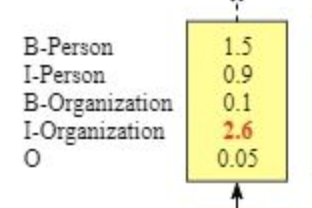

In [137]:
AL = torch.full((1, T), -10000.).to(device)
AL  #tensor([[-10000., -10000., -10000., -10000., -10000., -10000., -10000., -10000.,-10000.]])
tag_to_ix#BIO
tag_to_ix[START_TAG]#0
AL[0][0] = 0#tensor(-10000.)  --> tensor(0.)
AL[0][0]
AL  #tensor([[     0., -10000., -10000., -10000., -10000., -10000., -10000., -10000.,-10000.]])
FV = AL
FV# 用一个变量包裹，这样我们就能得到自动的反推。
tagset_size = len(tag_to_ix)
for f in F: 
  #print(F)   #所有的话的tensor【话，9】
  #print(f)#一句话tensor
  #弄个时间步长
  AT= []
  for NT in range(tagset_size):   #NT 0-8
    #print(NT)
    #print(f[NT])
    '''
    f[NT]每个词
    tensor(0.0253, grad_fn=<SelectBackward>)
    tensor(0.2595, grad_fn=<SelectBackward>)
    tensor(-0.2054, grad_fn=<SelectBackward>)
    tensor(0.0297, grad_fn=<SelectBackward>)
    tensor(-0.2240, grad_fn=<SelectBackward>)
    tensor(-0.0944, grad_fn=<SelectBackward>)
    tensor(-0.0685, grad_fn=<SelectBackward>)
    tensor(0.1490, grad_fn=<SelectBackward>)
    tensor(0.0933, grad_fn=<SelectBackward>)
    tensor(0.0488, grad_fn=<SelectBackward>)
    tensor(0.2240, grad_fn=<SelectBackward>)
    tensor(-0.1591, grad_fn=<SelectBackward>)
    tensor(0.1114, grad_fn=<SelectBackward>)
    tensor(-0.1926, grad_fn=<SelectBackward>)
    tensor(0.0736, grad_fn=<SelectBackward>)
    tensor(-0.0111, grad_fn=<SelectBackward>)
    tensor(0.2065, grad_fn=<SelectBackward>)
    tensor(0.0891, grad_fn=<SelectBackward>)
    ''' 
    print(f[NT].view(1, -1)) #reshape; reshape 成1行，列数由行数决定。所以-1；前一个是reshape成几行
    '''
    tensor([[0.0253]], grad_fn=<ViewBackward>)
    tensor([[0.2595]], grad_fn=<ViewBackward>)
    tensor([[-0.2054]], grad_fn=<ViewBackward>)
    tensor([[0.0297]], grad_fn=<ViewBackward>)
    tensor([[-0.2240]], grad_fn=<ViewBackward>)
    tensor([[-0.0944]], grad_fn=<ViewBackward>)
    tensor([[-0.0685]], grad_fn=<ViewBackward>)
    tensor([[0.1490]], grad_fn=<ViewBackward>)
    tensor([[0.0933]], grad_fn=<ViewBackward>)
    tensor([[0.0488]], grad_fn=<ViewBackward>)
    tensor([[0.2240]], grad_fn=<ViewBackward>)
    tensor([[-0.1591]], grad_fn=<ViewBackward>)
    tensor([[0.1114]], grad_fn=<ViewBackward>)
    tensor([[-0.1926]], grad_fn=<ViewBackward>)
    tensor([[0.0736]], grad_fn=<ViewBackward>)
    tensor([[-0.0111]], grad_fn=<ViewBackward>)
    tensor([[0.2065]], grad_fn=<ViewBackward>)
    tensor([[0.0891]], grad_fn=<ViewBackward>)
    '''
    #emit_score = f[NT].view(1, -1).expand(1, self.tagset_size) 


tensor([[0.0253]], grad_fn=<ViewBackward>)
tensor([[0.2595]], grad_fn=<ViewBackward>)
tensor([[-0.2054]], grad_fn=<ViewBackward>)
tensor([[0.0297]], grad_fn=<ViewBackward>)
tensor([[-0.2240]], grad_fn=<ViewBackward>)
tensor([[-0.0944]], grad_fn=<ViewBackward>)
tensor([[-0.0685]], grad_fn=<ViewBackward>)
tensor([[0.1490]], grad_fn=<ViewBackward>)
tensor([[0.0933]], grad_fn=<ViewBackward>)
tensor([[0.0488]], grad_fn=<ViewBackward>)
tensor([[0.2240]], grad_fn=<ViewBackward>)
tensor([[-0.1591]], grad_fn=<ViewBackward>)
tensor([[0.1114]], grad_fn=<ViewBackward>)
tensor([[-0.1926]], grad_fn=<ViewBackward>)
tensor([[0.0736]], grad_fn=<ViewBackward>)
tensor([[-0.0111]], grad_fn=<ViewBackward>)
tensor([[0.2065]], grad_fn=<ViewBackward>)
tensor([[0.0891]], grad_fn=<ViewBackward>)


In [75]:
#开始定义的feat？[分析主题流程]
#【1】
def neg_log_likelihood(self, sentence, tags):  #sentence_in； targets都是index  （词典ind；IBOind）
    feats = self._get_lstm_features(sentence)   #词典ind做_get_lstm_features 【分析了23.】feats 就是那一堆BIO概率；从lSTM出来的结果
    #feats =F 好多句tensor[-0.0099,  0.1274, -0.1200, -0.1195, -0.1803, -0.2581,  0.0604, -0.0509, 0.0623],
    #【4】_forward_alg
    forward_score = self._forward_alg(feats)
    gold_score = self._score_sentence(feats, tags)
    return forward_score - gold_score

#【2】
def _get_lstm_features(self, sentence):   #sentence_in；词典ind
    self.hidden = self.init_hidden()   #hidden = init_hidden #hidden = 随机返回两个【2，1，25】init_hidden __init__ =hidden 在下面定义了。【3】随机了矩阵torch
    embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)    #embeds = E
     #self.word_embeds = nn.Embedding(vocab_size, embedding_dim) 2351，25 #word_embeds = WE
     #给输入的词创建词向量 nn.Embedding高度是2351；长度是12
     # self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))
    lstm_out, self.hidden = self.lstm(embeds, self.hidden)    # lstm = L 结果是l  lstm_out = O hidden = H
    #lstm __init__
    #self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)#" // " 表示整数除法  25;50//2 ==25
    #list层
    lstm_out = lstm_out.view(len(sentence), self.hidden_dim)  #转个维度 lstm_out =O2
    lstm_feats = self.hidden2tag(lstm_out)  #hidden2tag 线性层 LN（O2)  lstm_feats = F
    # Maps the output of the LSTM into tag space. 将LSTM的输出映射到标签空间。
    #self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)   # 50,9 tagset_size =len(tag_to_ix) = T
    #Linear(in_features=50, out_features=9, bias=True)
    return lstm_feats               #lstm_feats 列句子 行是IBO典长度 
     '''？？为什么用ibo典的长度。输出各种可能性BIO的'''

#【3】
def init_hidden(self):  ##hidden = 随机返回两个【2，1，25】 A   你可以随机初始化转移矩阵的分数。这些分数将随着训练的迭代过程被更新，换句话说，CRF层可以自己学到这些约束条件。
    return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
            torch.randn(2, 1, self.hidden_dim // 2).to(device))
    
#【4】_forward_alg（F） --return alpha
def _forward_alg(self, feats):    #F
    # Do the forward algorithm to compute the partition function # 做正向算法来计算分区函数
    init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)  #tagset_size =len(tag_to_ix) = T
    #init_alphas = AL
     #torch.full创建全相同的张量 [1,9]
    # START_TAG has all of the score. START_TAG有所有的分数。
    init_alphas[0][self.tag_to_ix[START_TAG]] = 0. # AL[0][0]init_alphas=AL

    # Wrap 包裹in a variable so that we will get automatic backprop # 用一个变量包裹，这样我们就能得到自动的反推。

    forward_var = init_alphas #FV # 用一个变量包裹，这样我们就能得到自动的反推。
    '''什么叫automatic backprop？？'''
    # Iterate through the sentence   遍历该句子
    for feat in feats:    #feat =f feats = F
        #时间步长
        alphas_t = []  # alphas_t = [] = AT； The forward tensors at this timestep  在这个时间步长的前向张量alphas_t = [] = AT
        for next_tag in range(self.tagset_size):  #next_tag = NT ;#NT 0-8; tageset_size = len(tage_to_ix) len(BIO)
            # broadcast the emission score: it is the same regardless of 播出排放分数：不管是哪种情况，它都是一样的。
            # the previous tag前一个标签
            emit_score = feat[next_tag].view(
                1, -1).expand(1, self.tagset_size)
            # the ith entry of trans_score is the score of transitioning to
            # next_tag from i
            trans_score = self.transitions[next_tag].view(1, -1)
            # The ith entry of next_tag_var is the value for the
            # edge (i -> next_tag) before we do log-sum-exp
            next_tag_var = forward_var + trans_score + emit_score
            # The forward variable for this tag is log-sum-exp of all the
            # scores.
            alphas_t.append(log_sum_exp(next_tag_var).view(1))
        forward_var = torch.cat(alphas_t).view(1, -1)
    terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    alpha = log_sum_exp(terminal_var)
    return alpha



In [63]:
tags_index = val_output_index[i] 
targets = torch.tensor(tags_index, dtype=torch.long).to(device)
sentence_in = torch.tensor(idxs, dtype=torch.long).to(device) 
loss = model.neg_log_likelihood(sentence_in, targets)
loss

tensor([4.8133], grad_fn=<SubBackward0>)

In [59]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).to(device)
model

BiLSTM_CRF(
  (word_embeds): Embedding(2351, 25)
  (lstm): LSTM(25, 25, bidirectional=True)
  (hidden2tag): Linear(in_features=50, out_features=9, bias=True)
)

In [56]:
sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
sentence_in
idxs

[261, 1877]

In [53]:
val_input_index[:2]
for i, idxs in enumerate(val_input_index[:3]):
  print(i)
  print(idxs)
  print(val_output_index[i])
print('\n')
val_output_index[:2]


0
[0]
[2]
1
[1874, 636, 1875, 210, 775, 154, 382, 117, 1876, 1798, 9]
[2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2]
2
[261, 1877]
[6, 2]




[[2], [2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2]]

### Testing

In [ ]:
# Call the cal_acc functions you implemented as required根据需要调用你实现的cal_acc函数
y_pred, y_true, _ = cal_acc(model,test_input_index,test_output_index)

def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]

y_true_decode = decode_output(y_true)
y_pred_decode = decode_output(y_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true_decode,y_pred_decode,digits=4))
# The log below is the sample output for this section